# Homework 1

### Installing packages

In [22]:
!pip install langchain_google_genai


## Setup your API key

To run the following cell, your API key must be stored it in a Colab Secret named `VERTEX_API_KEY`.


1.   Look for the key icon on the left panel of your colab.
2.   Under `Name`, create `VERTEX_API_KEY`.
3. Copy your key to `Value`.




In [23]:
from google.colab import userdata
GEMINI_VERTEX_API_KEY = userdata.get('GEMINI_API_KEY')

## Downloading receipts.zip
The codes below download and unzip receipts.zip from Google Drive. receipts.zip contains all images from the Fusion folder on BlackBoard.


In [24]:
import gdown
file_id = "1oe2FZd3ZTO7nrDqjCafNvxicl08oF8JF"
download_url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(download_url, "receipts.zip", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1oe2FZd3ZTO7nrDqjCafNvxicl08oF8JF
To: /content/receipts.zip
100%|██████████| 1.61M/1.61M [00:00<00:00, 35.4MB/s]


'receipts.zip'

In [25]:
!unzip receipts.zip

Archive:  receipts.zip
replace receipt1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## 1. Helper functions

We need two functions
* image_to_base64 convert your jpg image into Base64 encoded string (basically a sequence of 64 characters to make your image easily transfered via API)
* get_image_data_url takes your jpg image, converting them into base64 string and construct a suitable input for GEMINI api call.

In [26]:
import base64
import mimetypes

# Helper function to read and encode image
def image_to_base64(img_path):
    with open(img_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode('utf-8')

# Helper function to encode local file to Base64 Data URL
def get_image_data_url(image_path):
    # Guess the mime type (e.g., image/png, image/jpeg) based on file extension
    mime_type, _ = mimetypes.guess_type(image_path)
    if mime_type is None:
        mime_type = "image/png" # Default fallback

    encoded_string = image_to_base64(image_path)

    # Construct the Data URL
    return f"data:{mime_type};base64,{encoded_string}"

In [27]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    api_key=userdata.get('GEMINI_API_KEY'), # Ensure this key is set in Colab secrets
    temperature=0,
    vertexai=False
)

Display jpg images. Alternatively, open the folder icon on the left pannel to see the images.


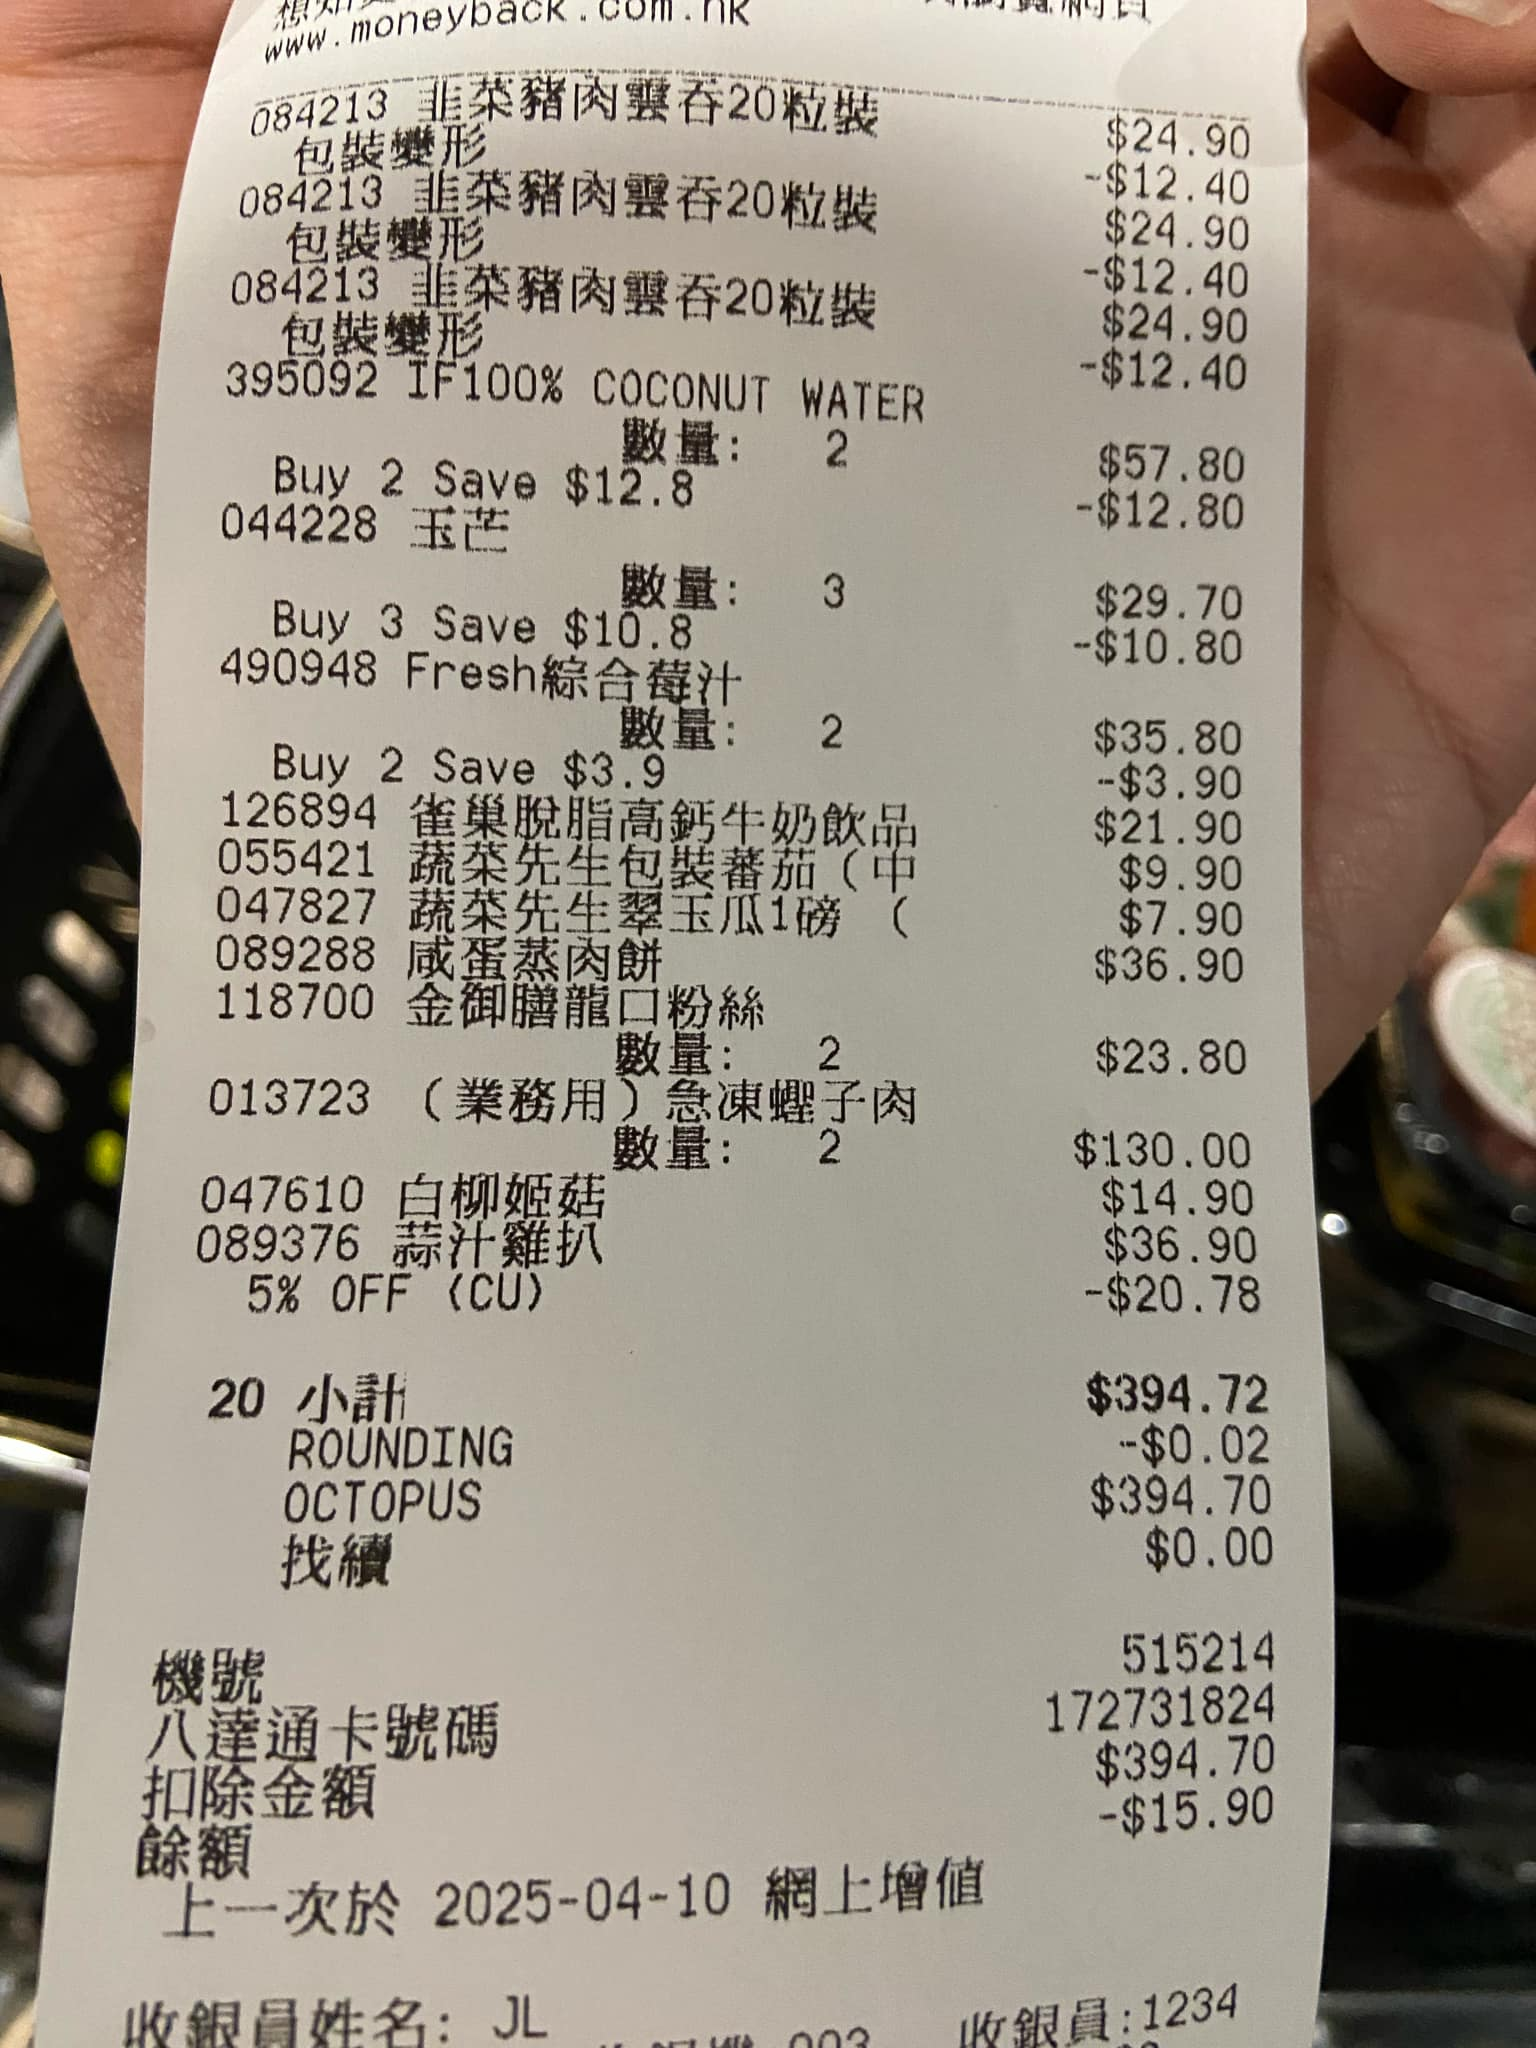
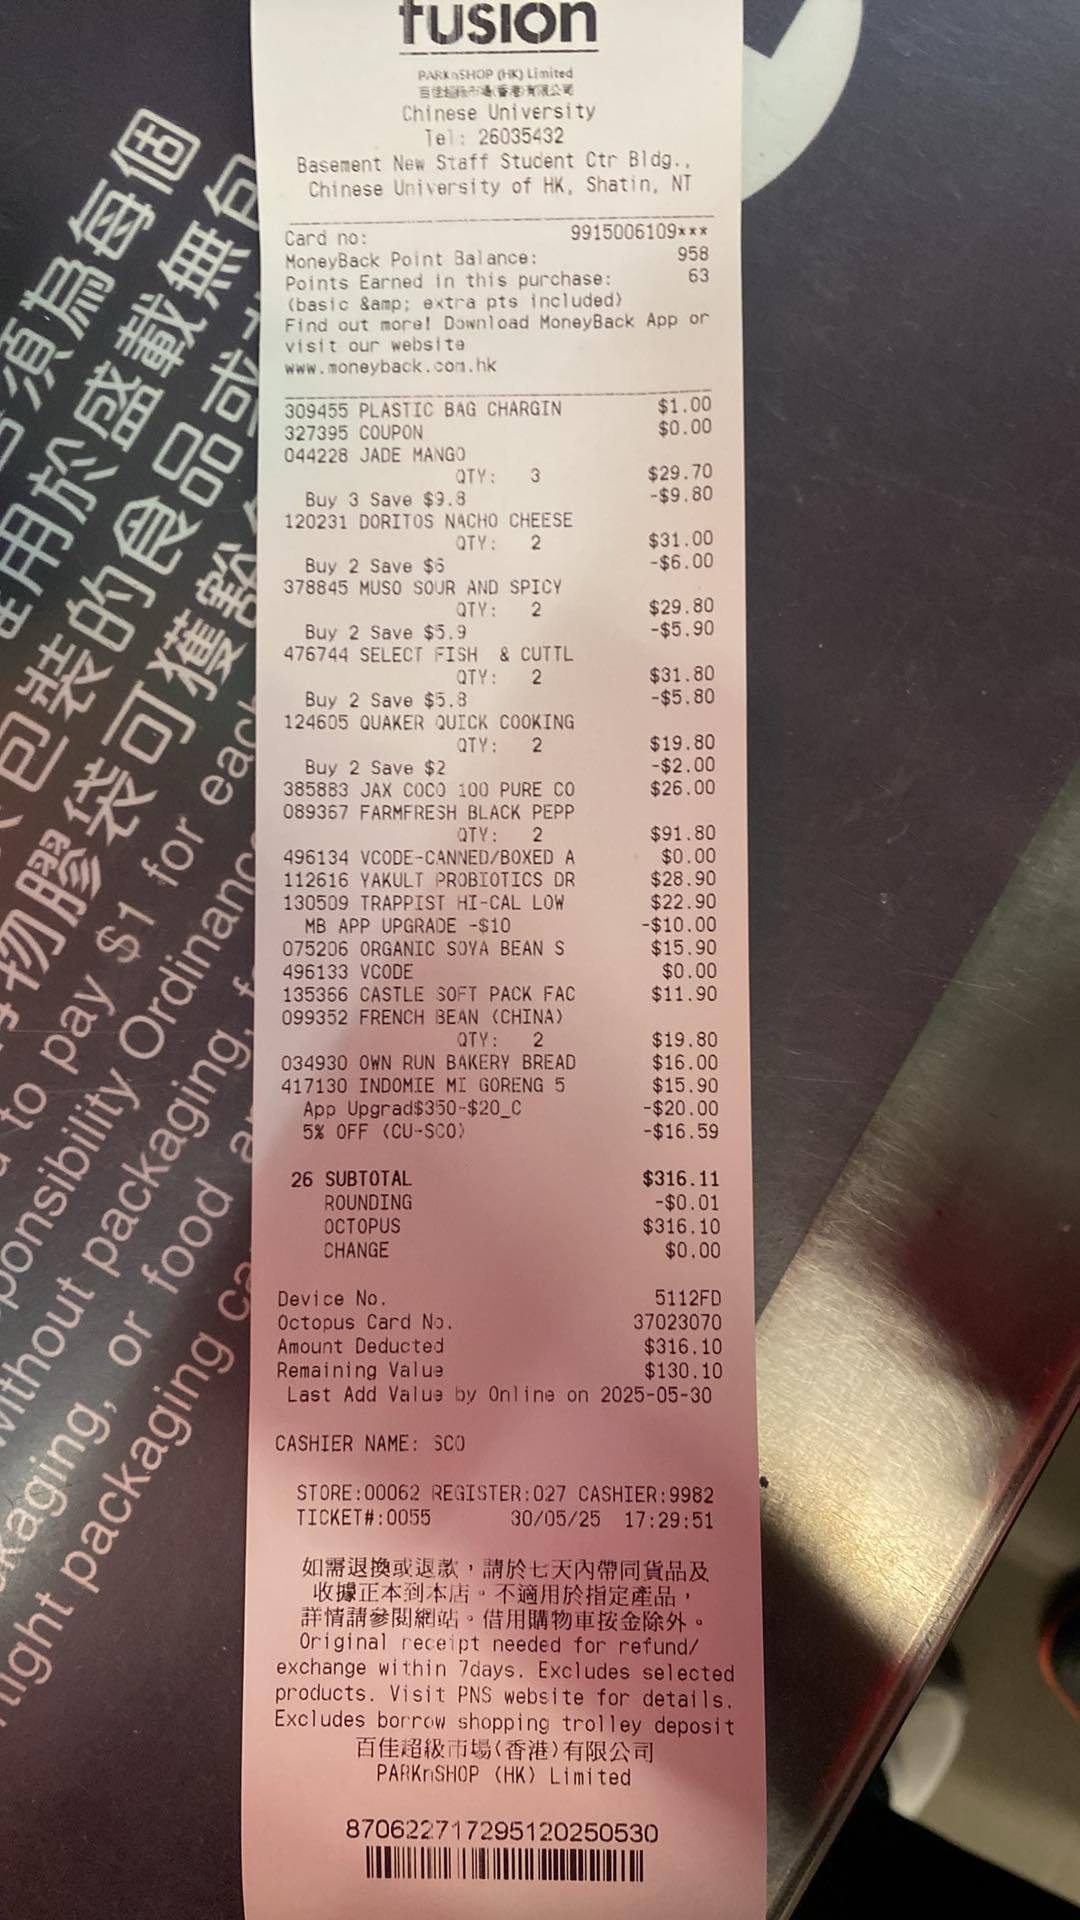
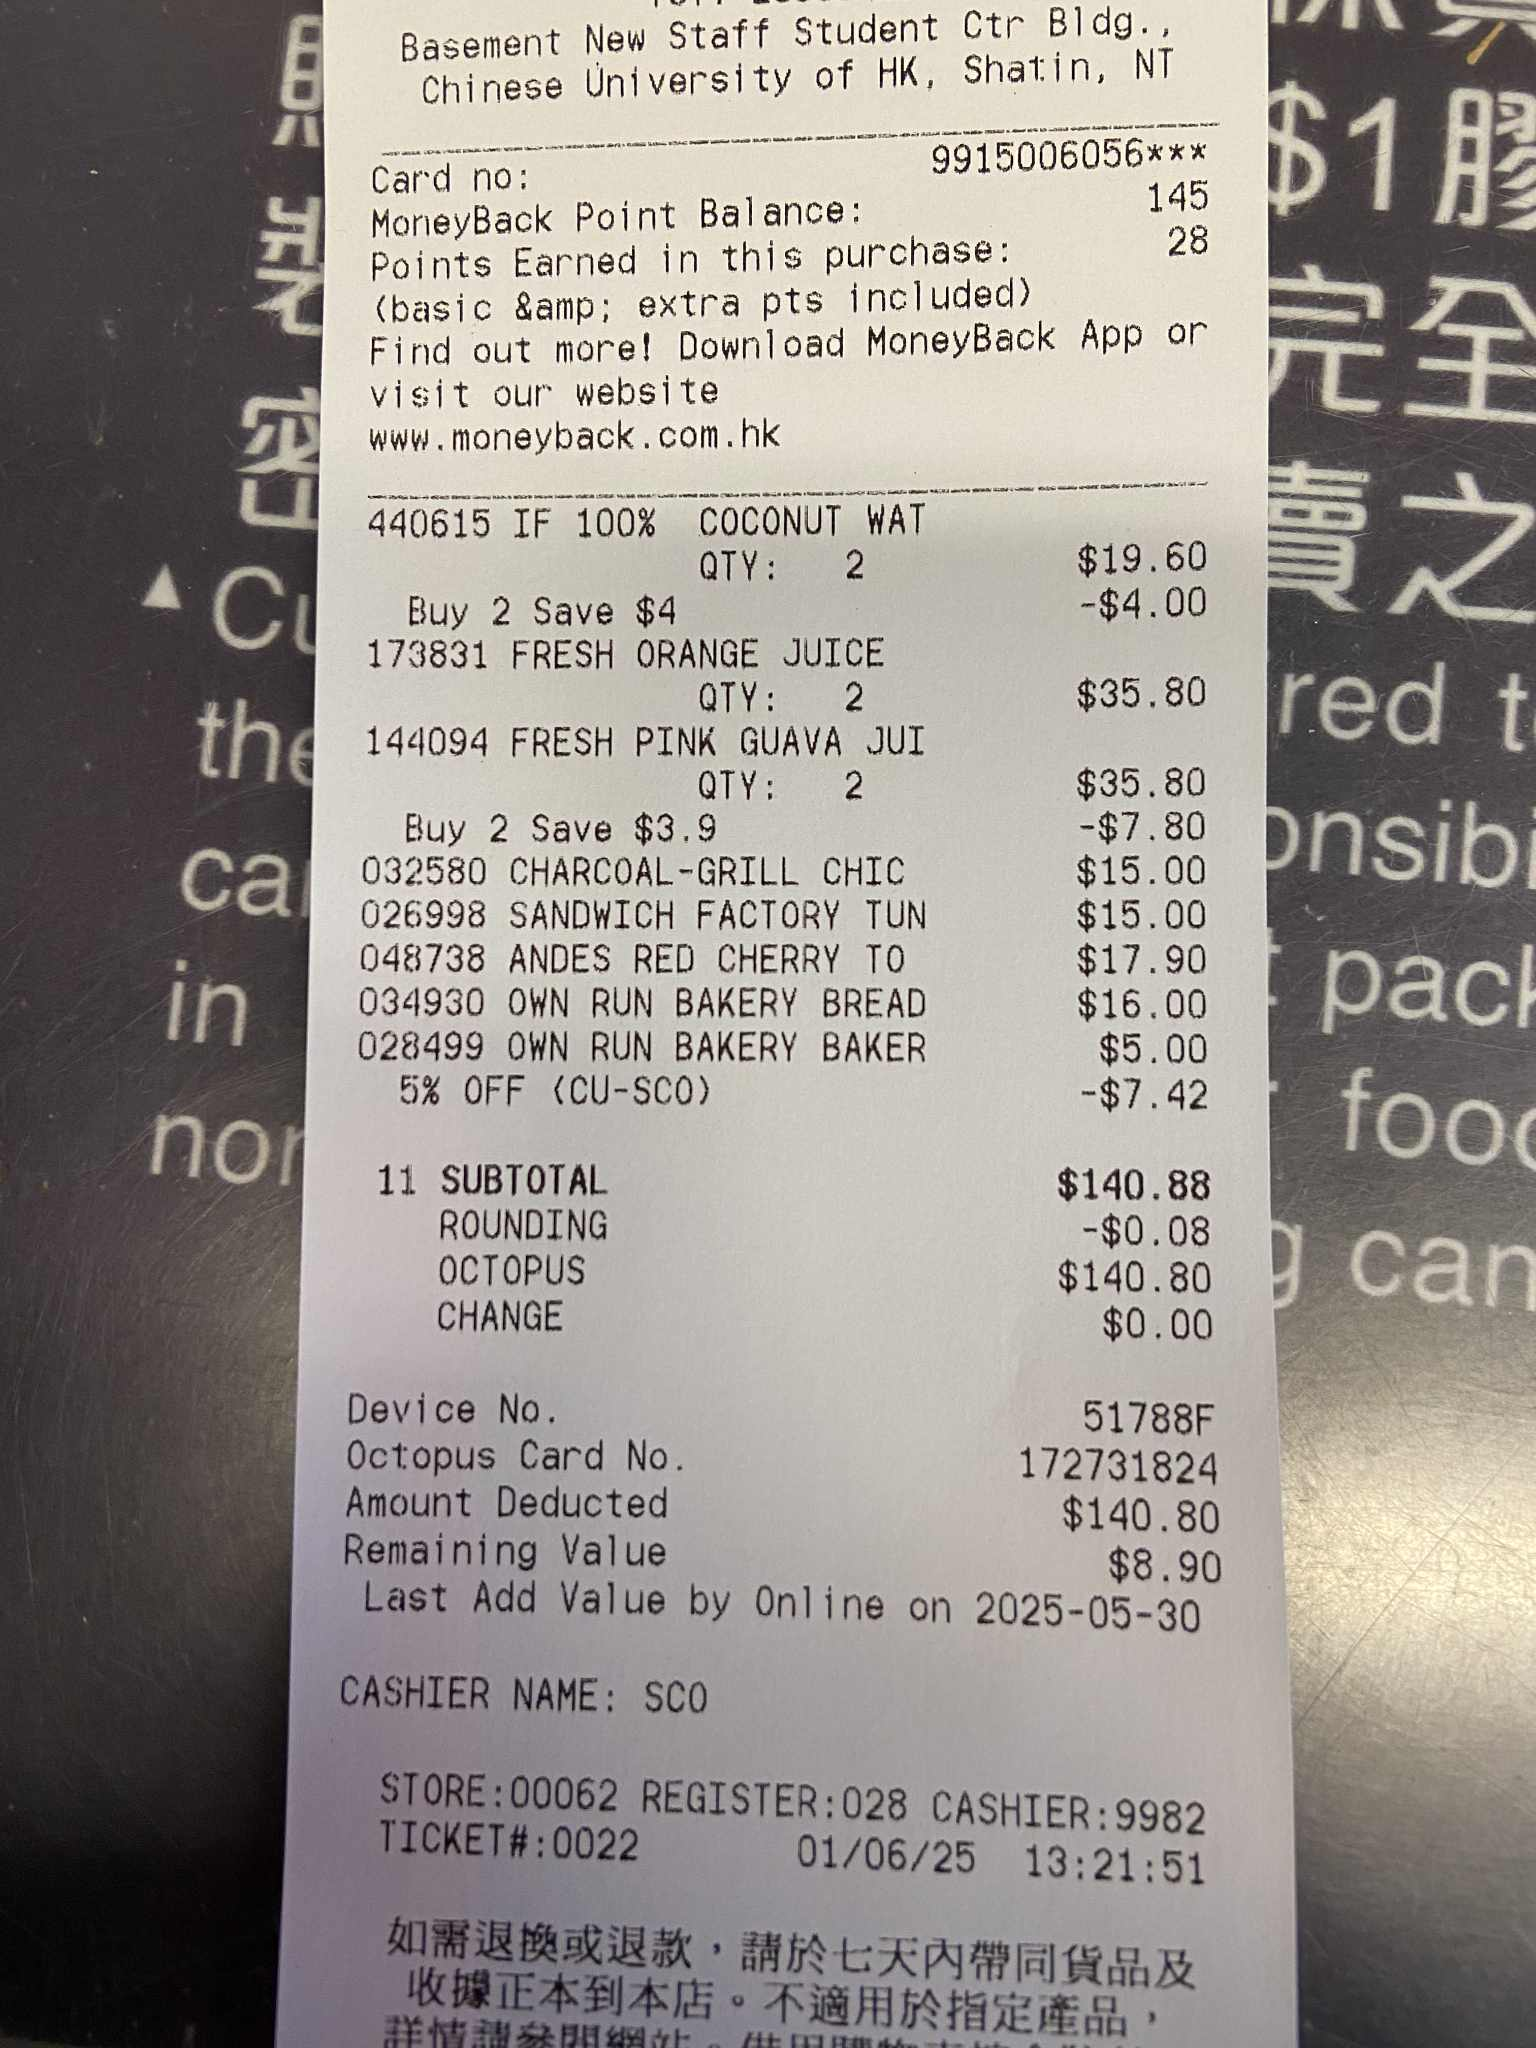
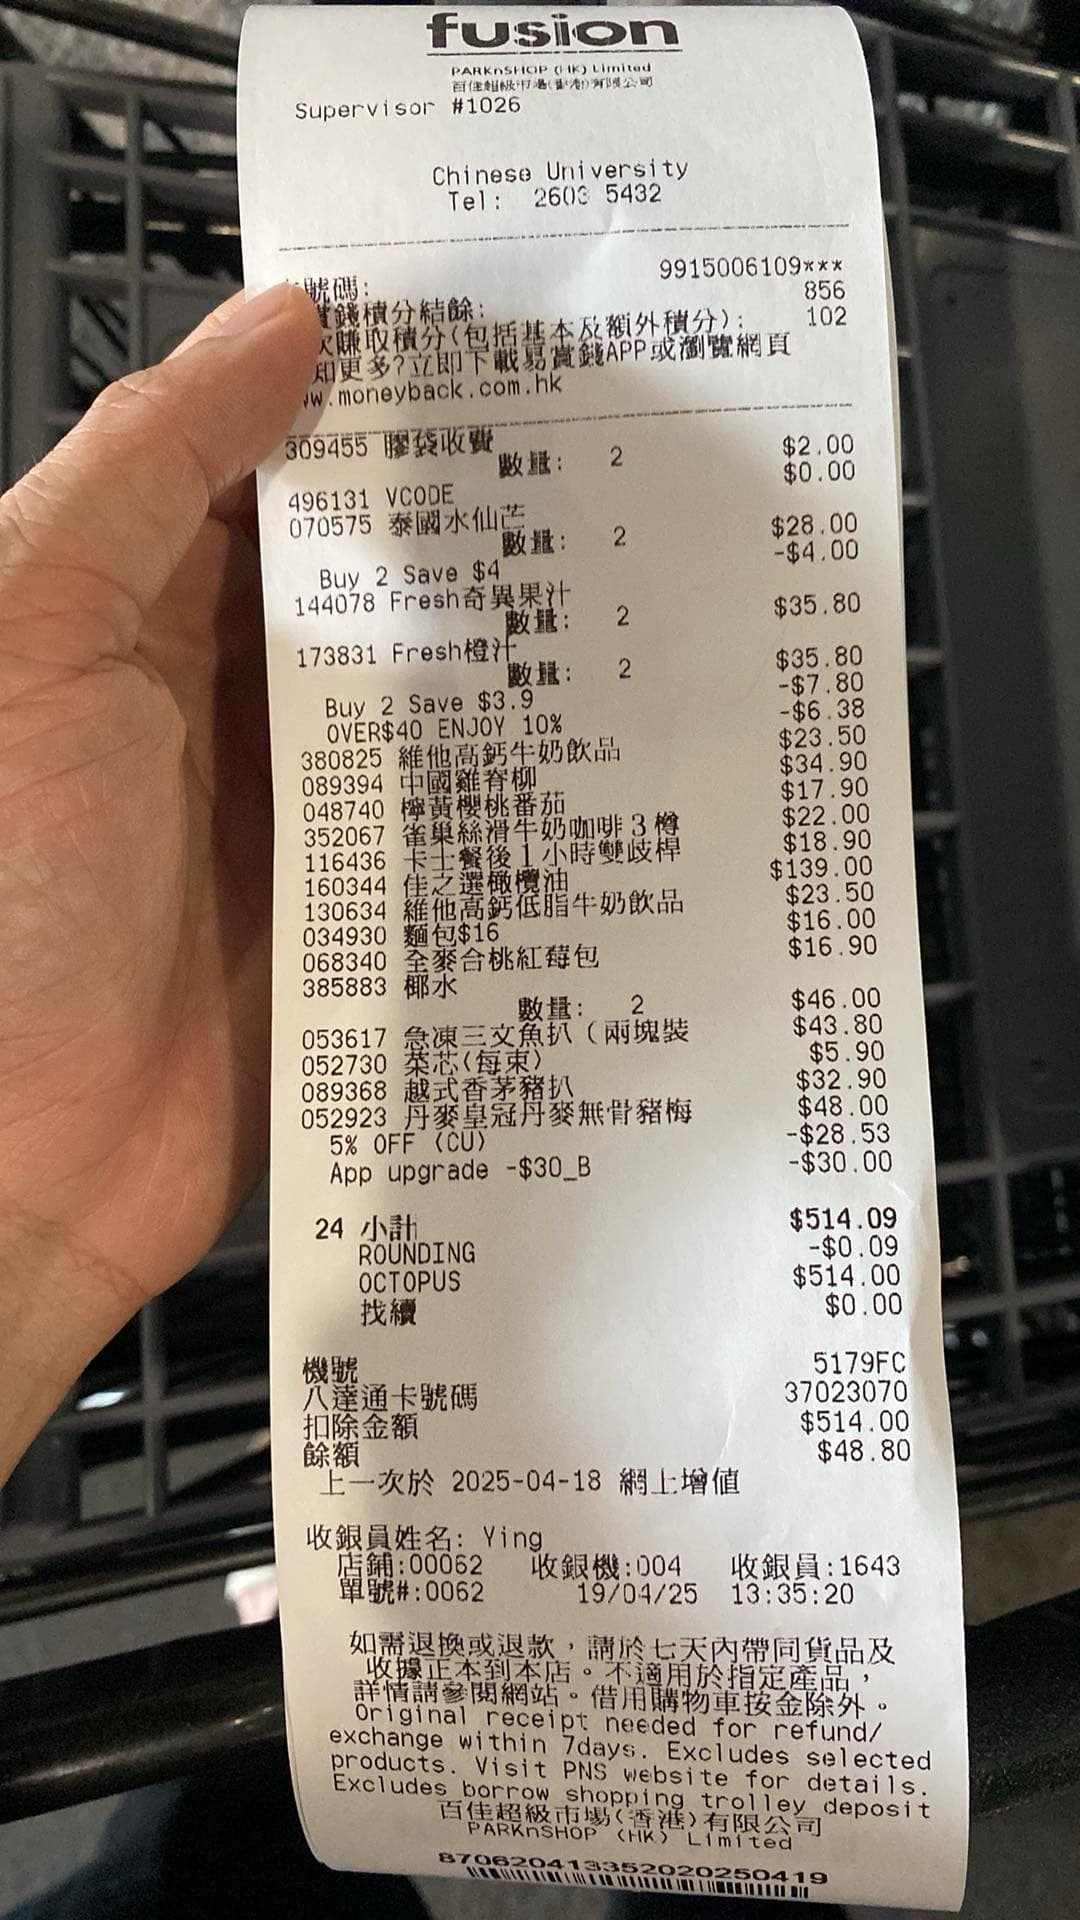
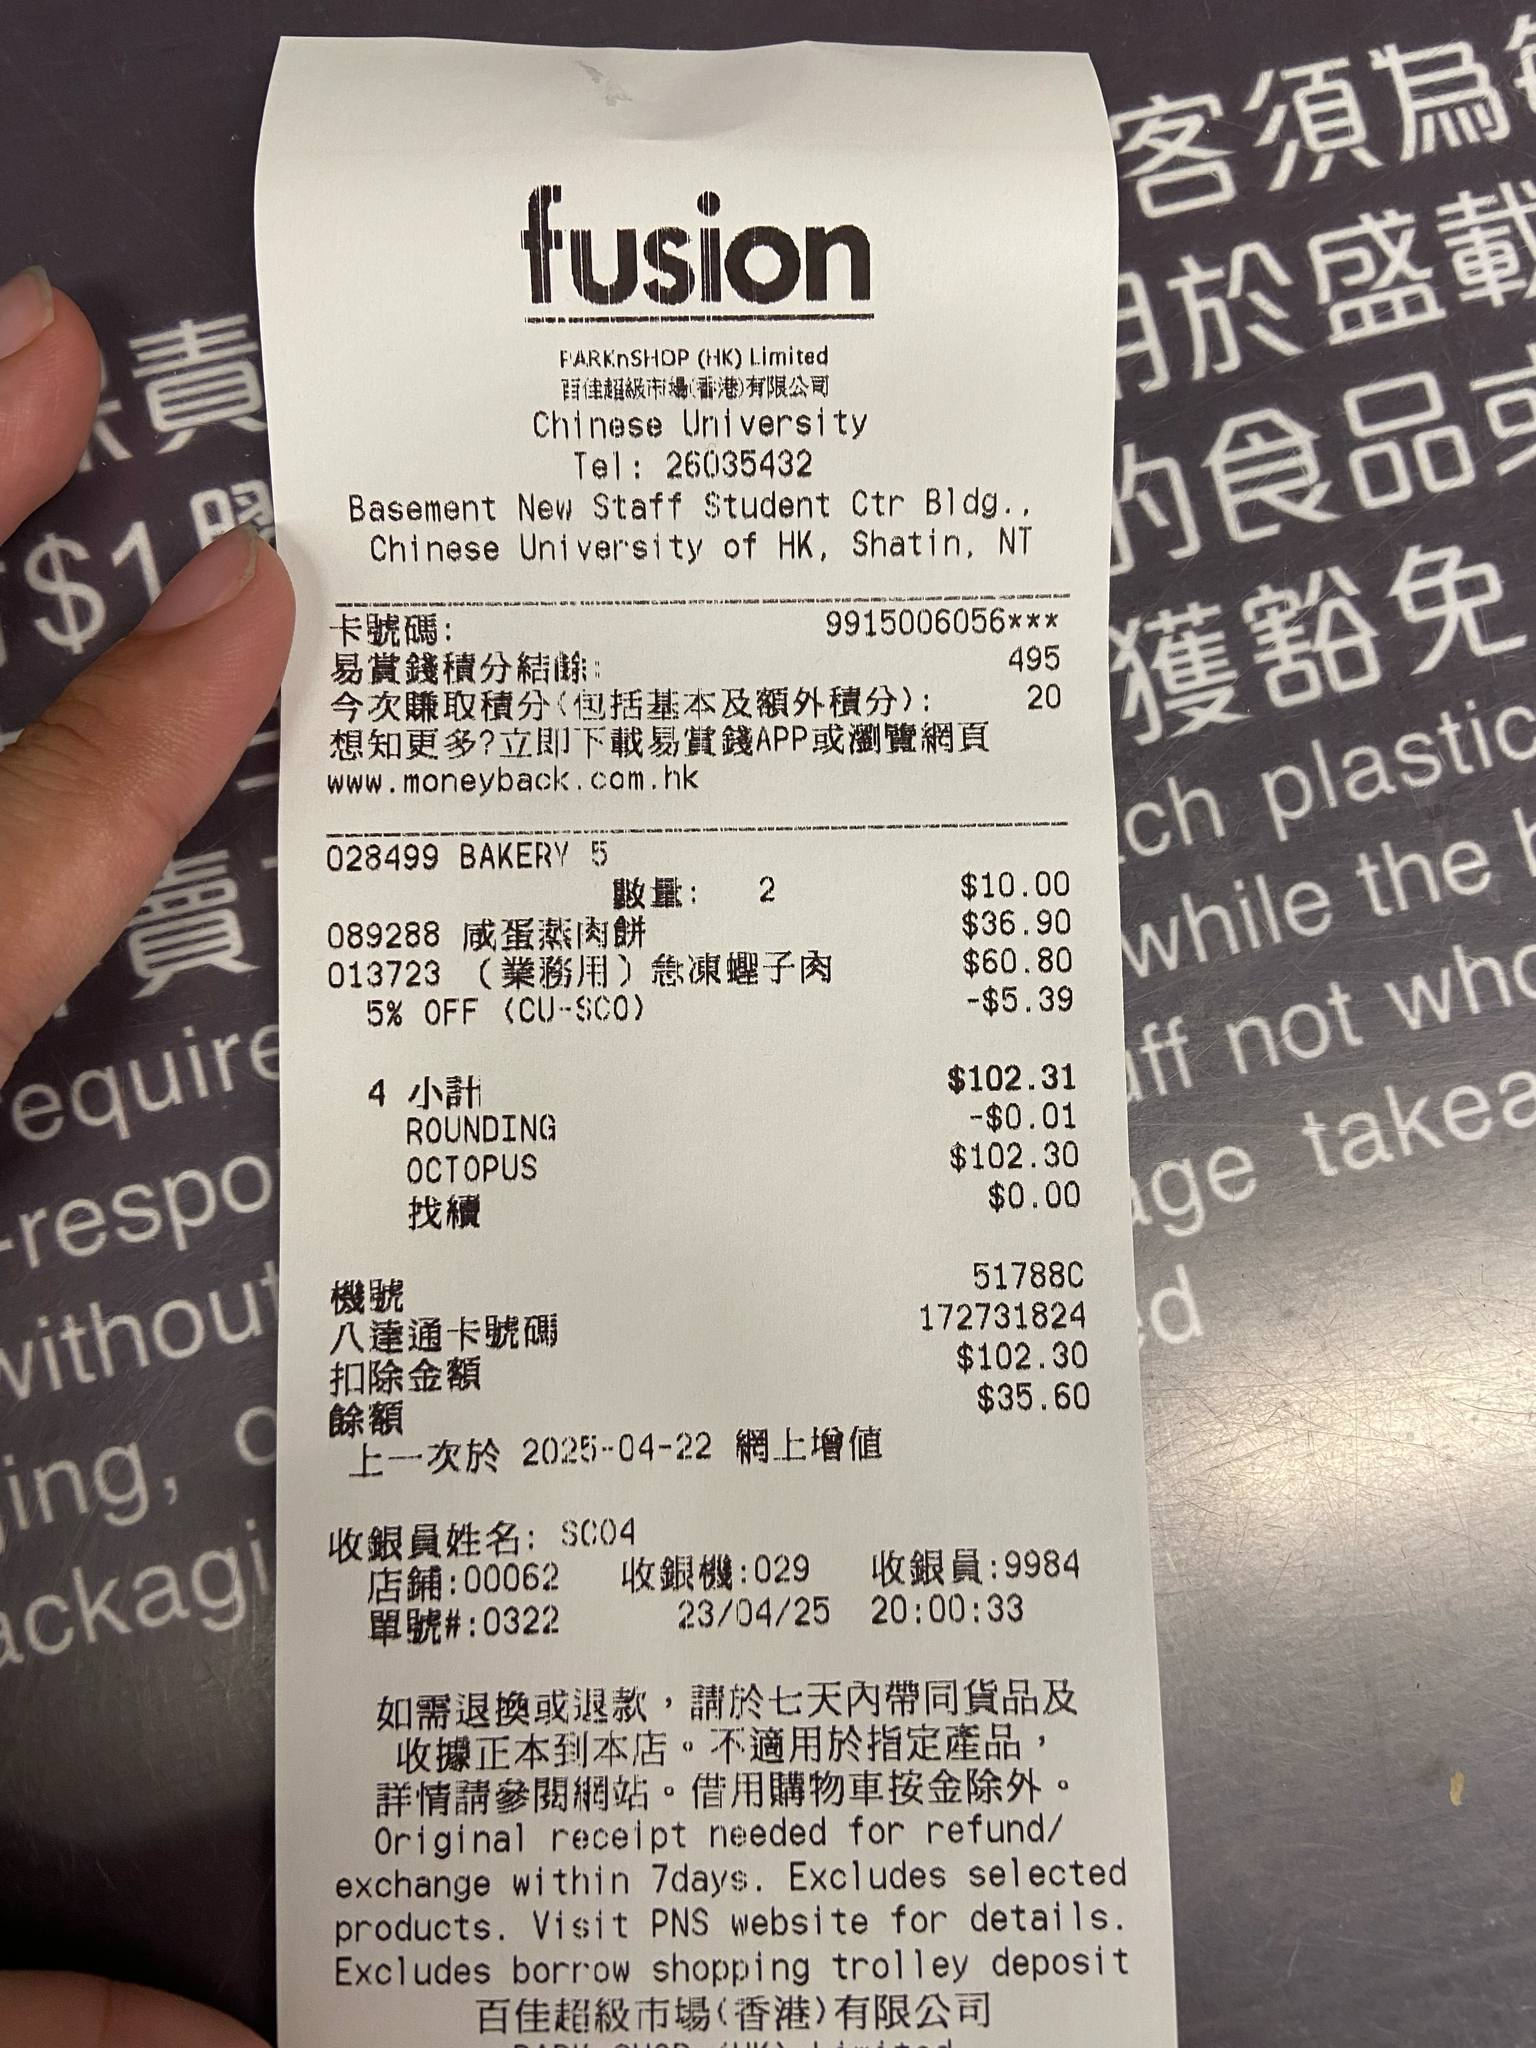
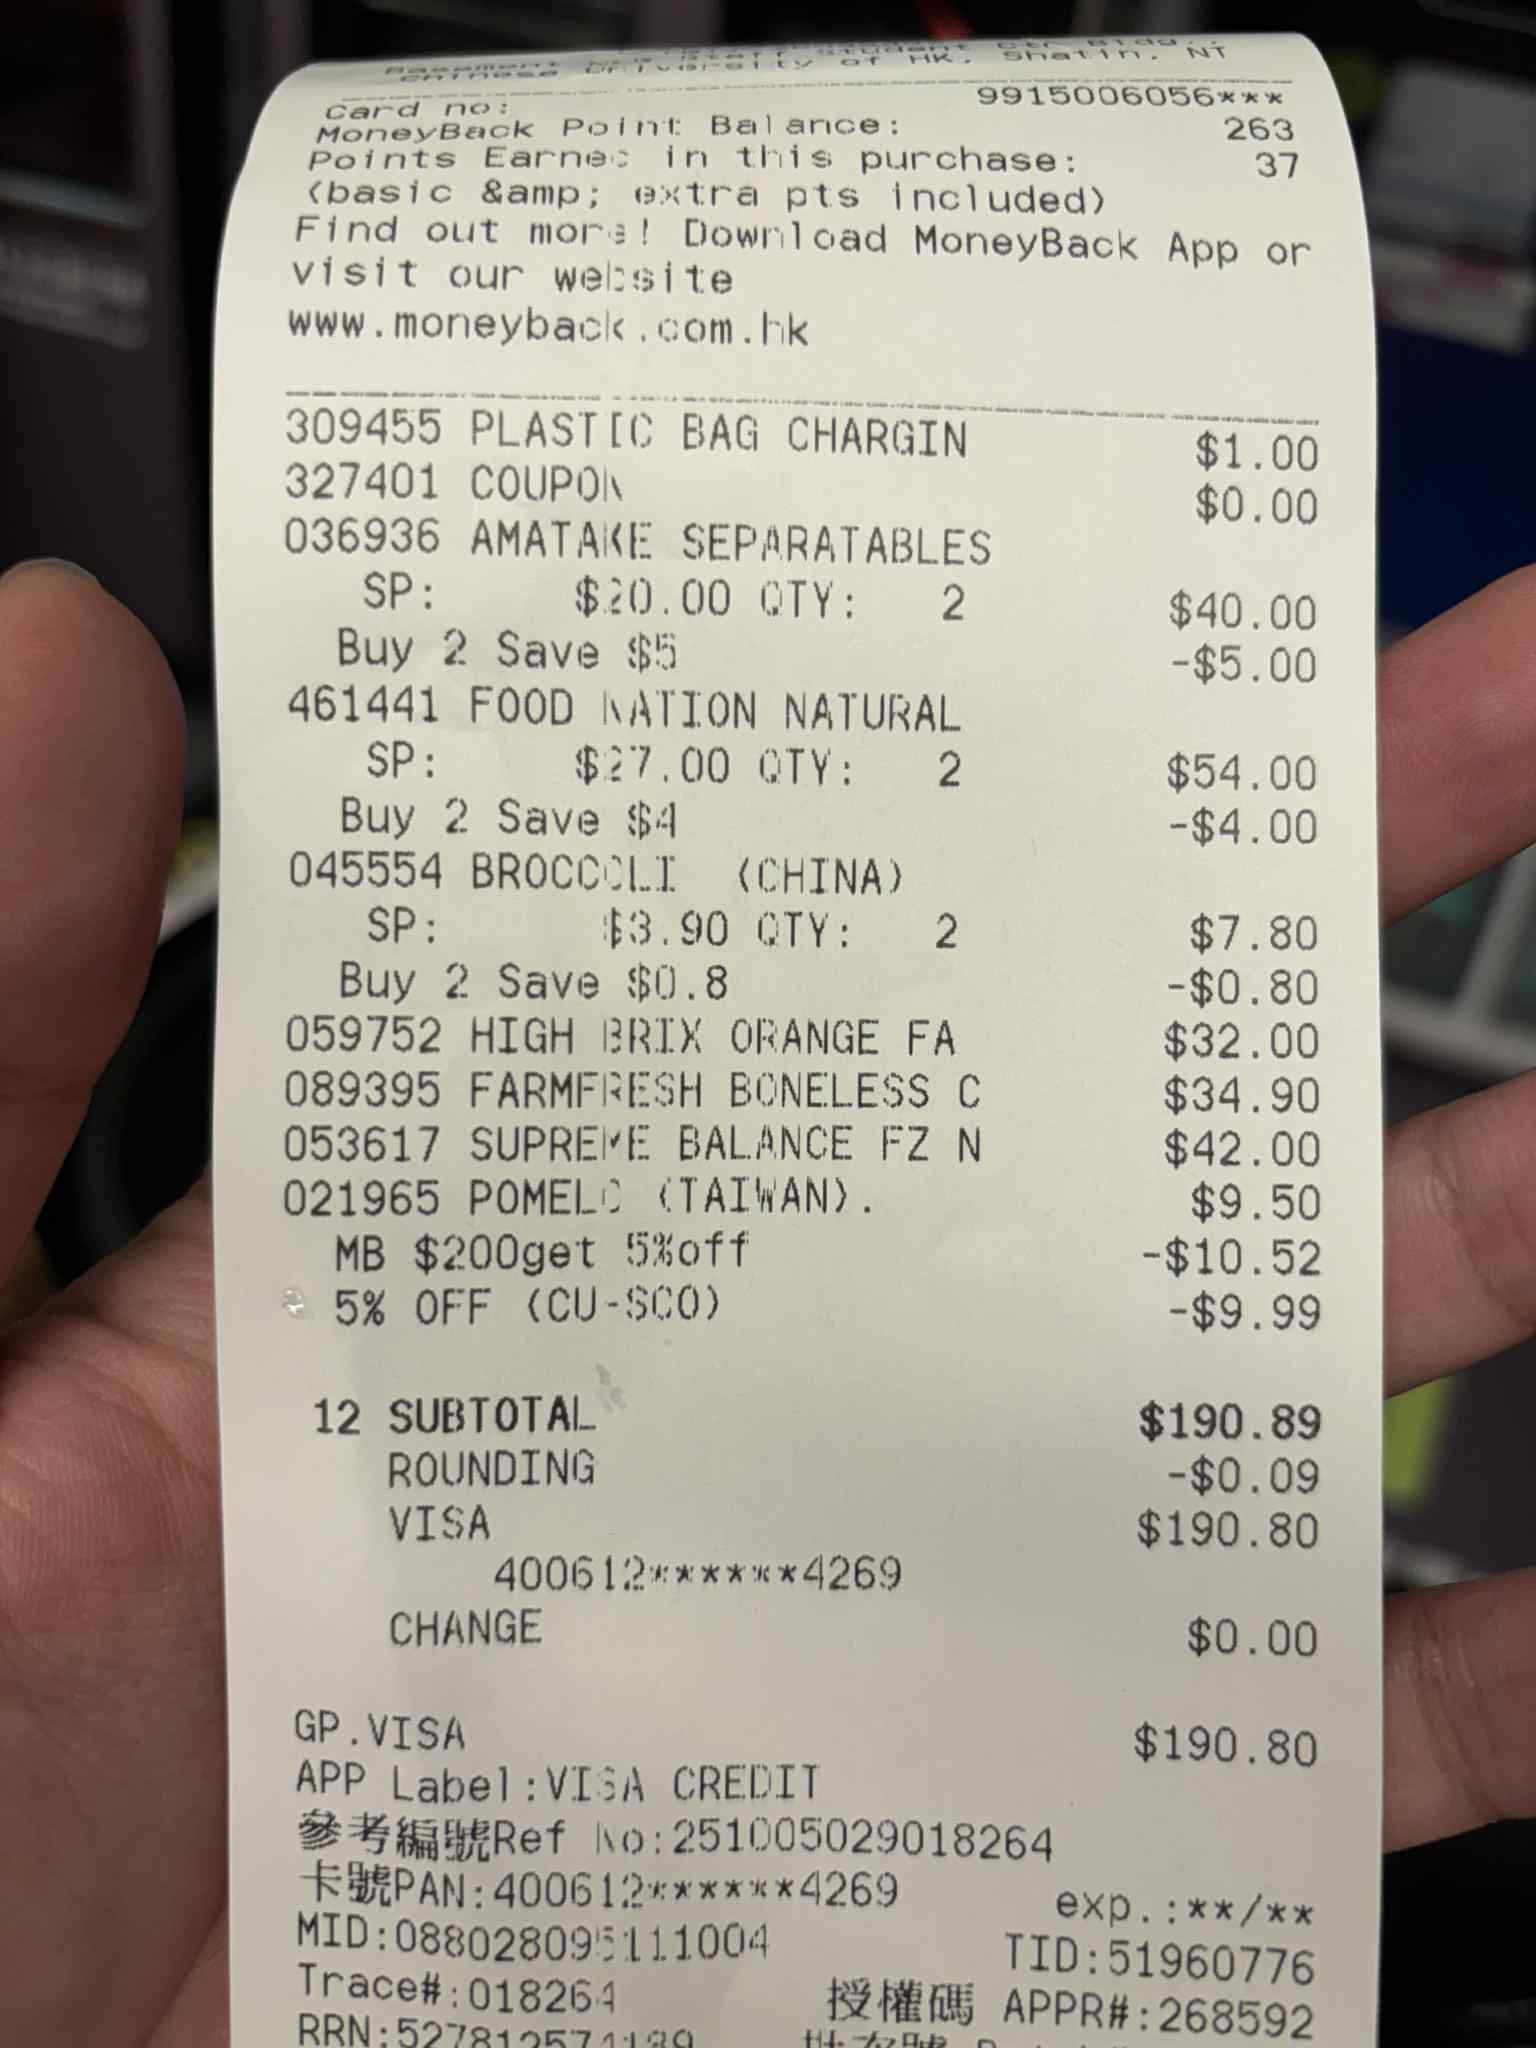
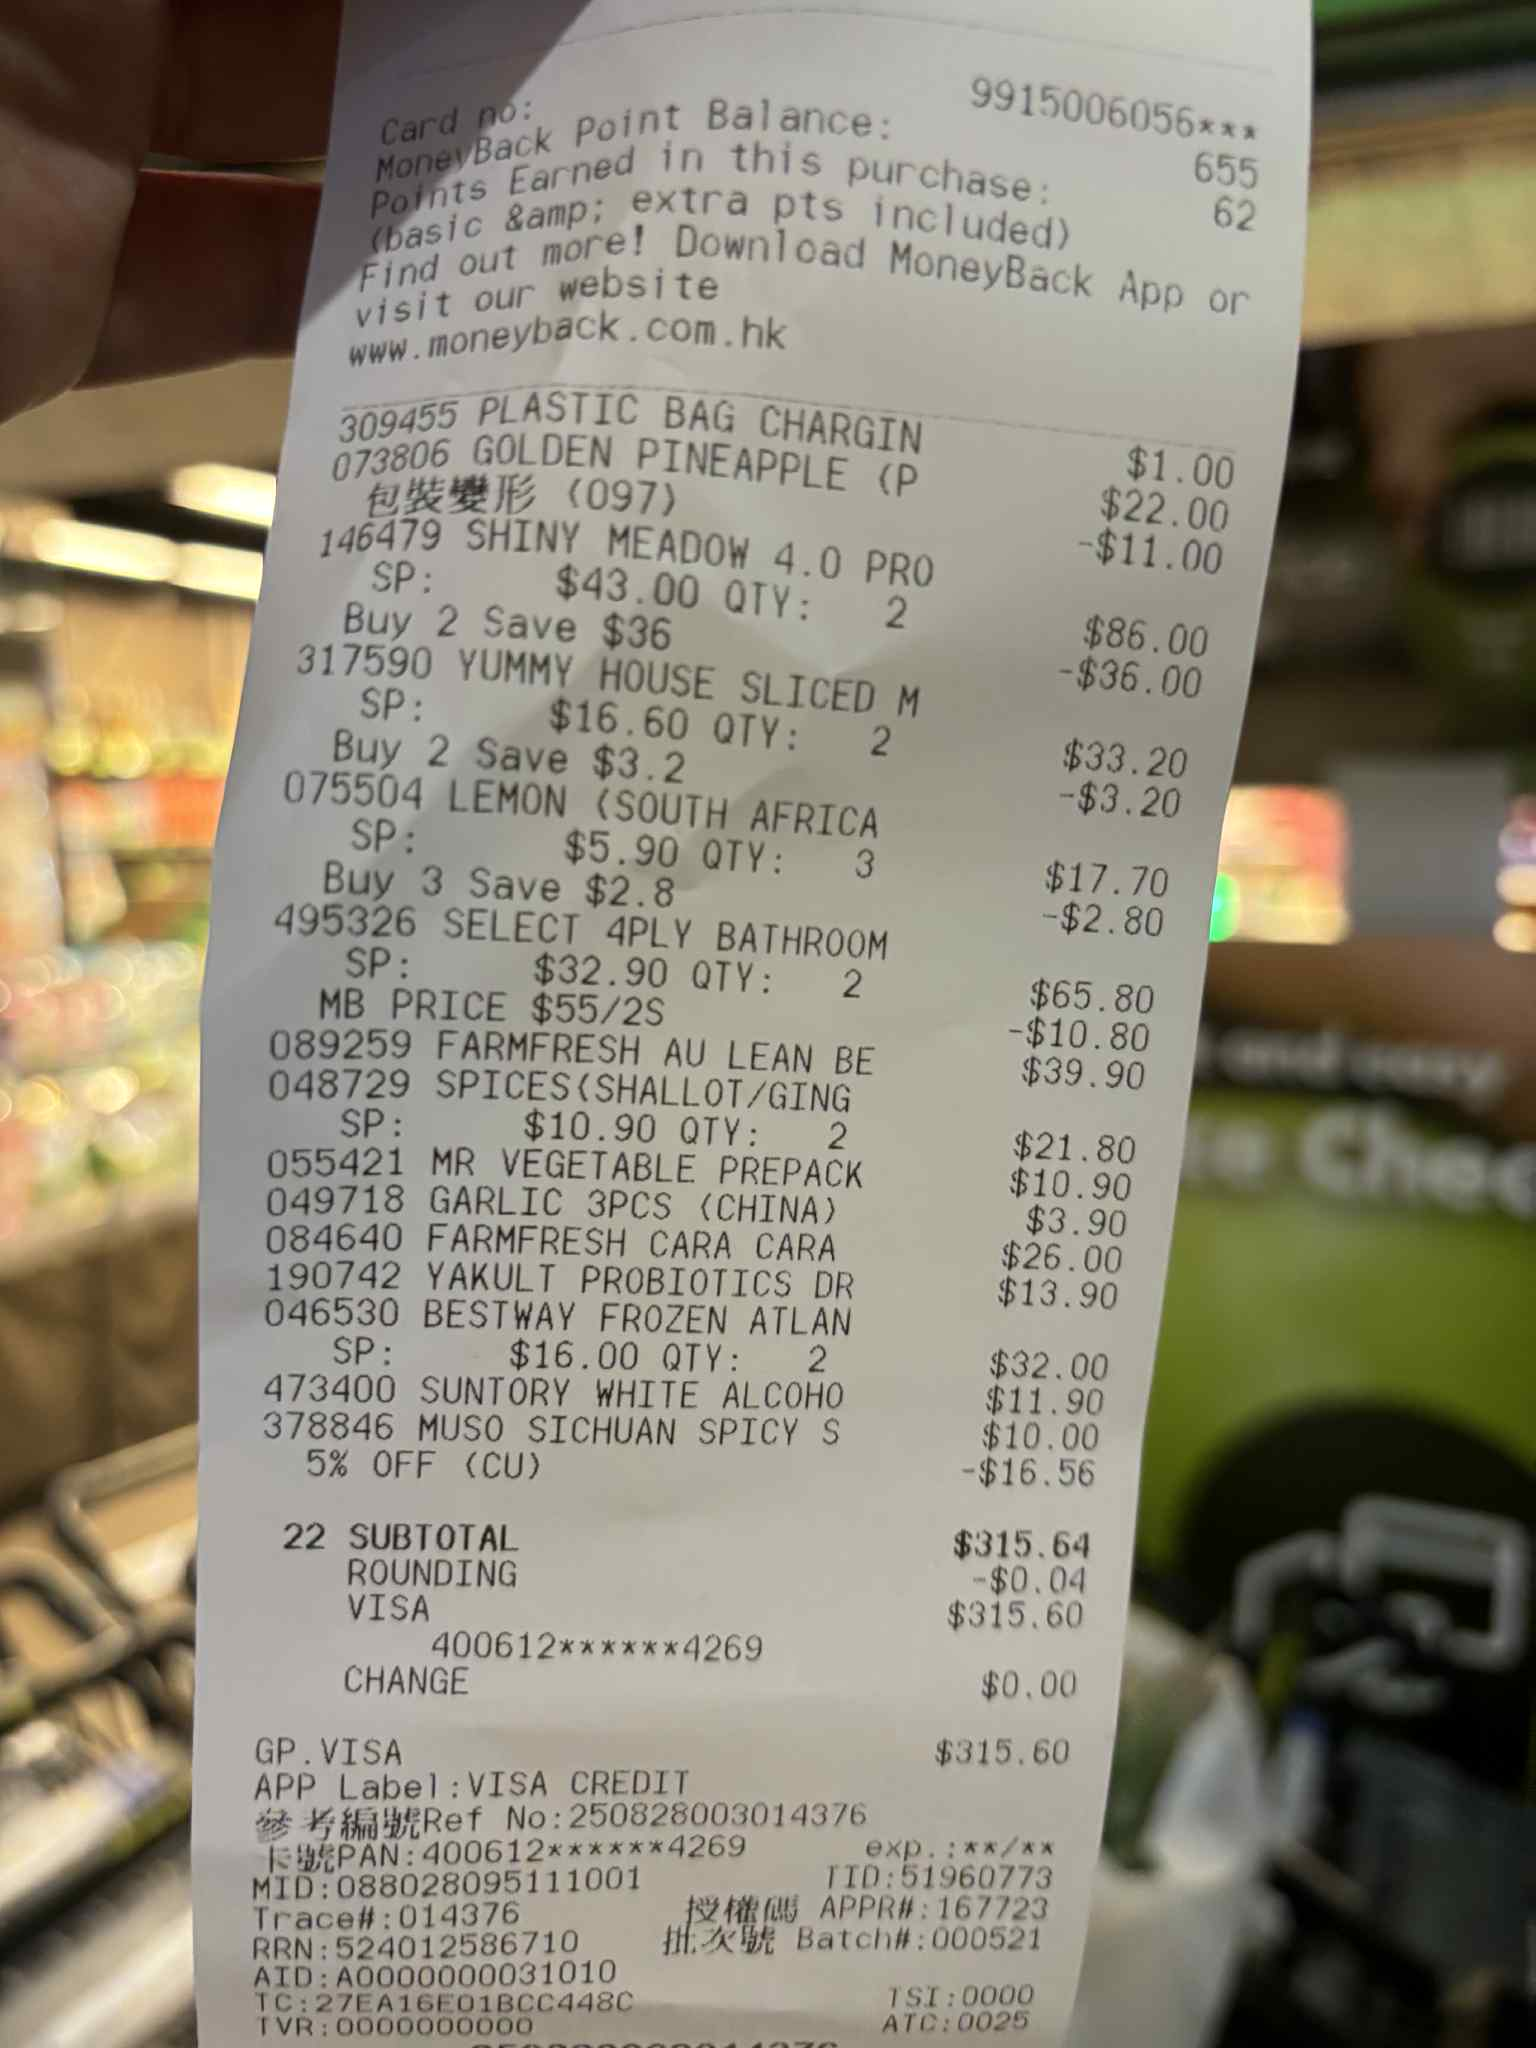
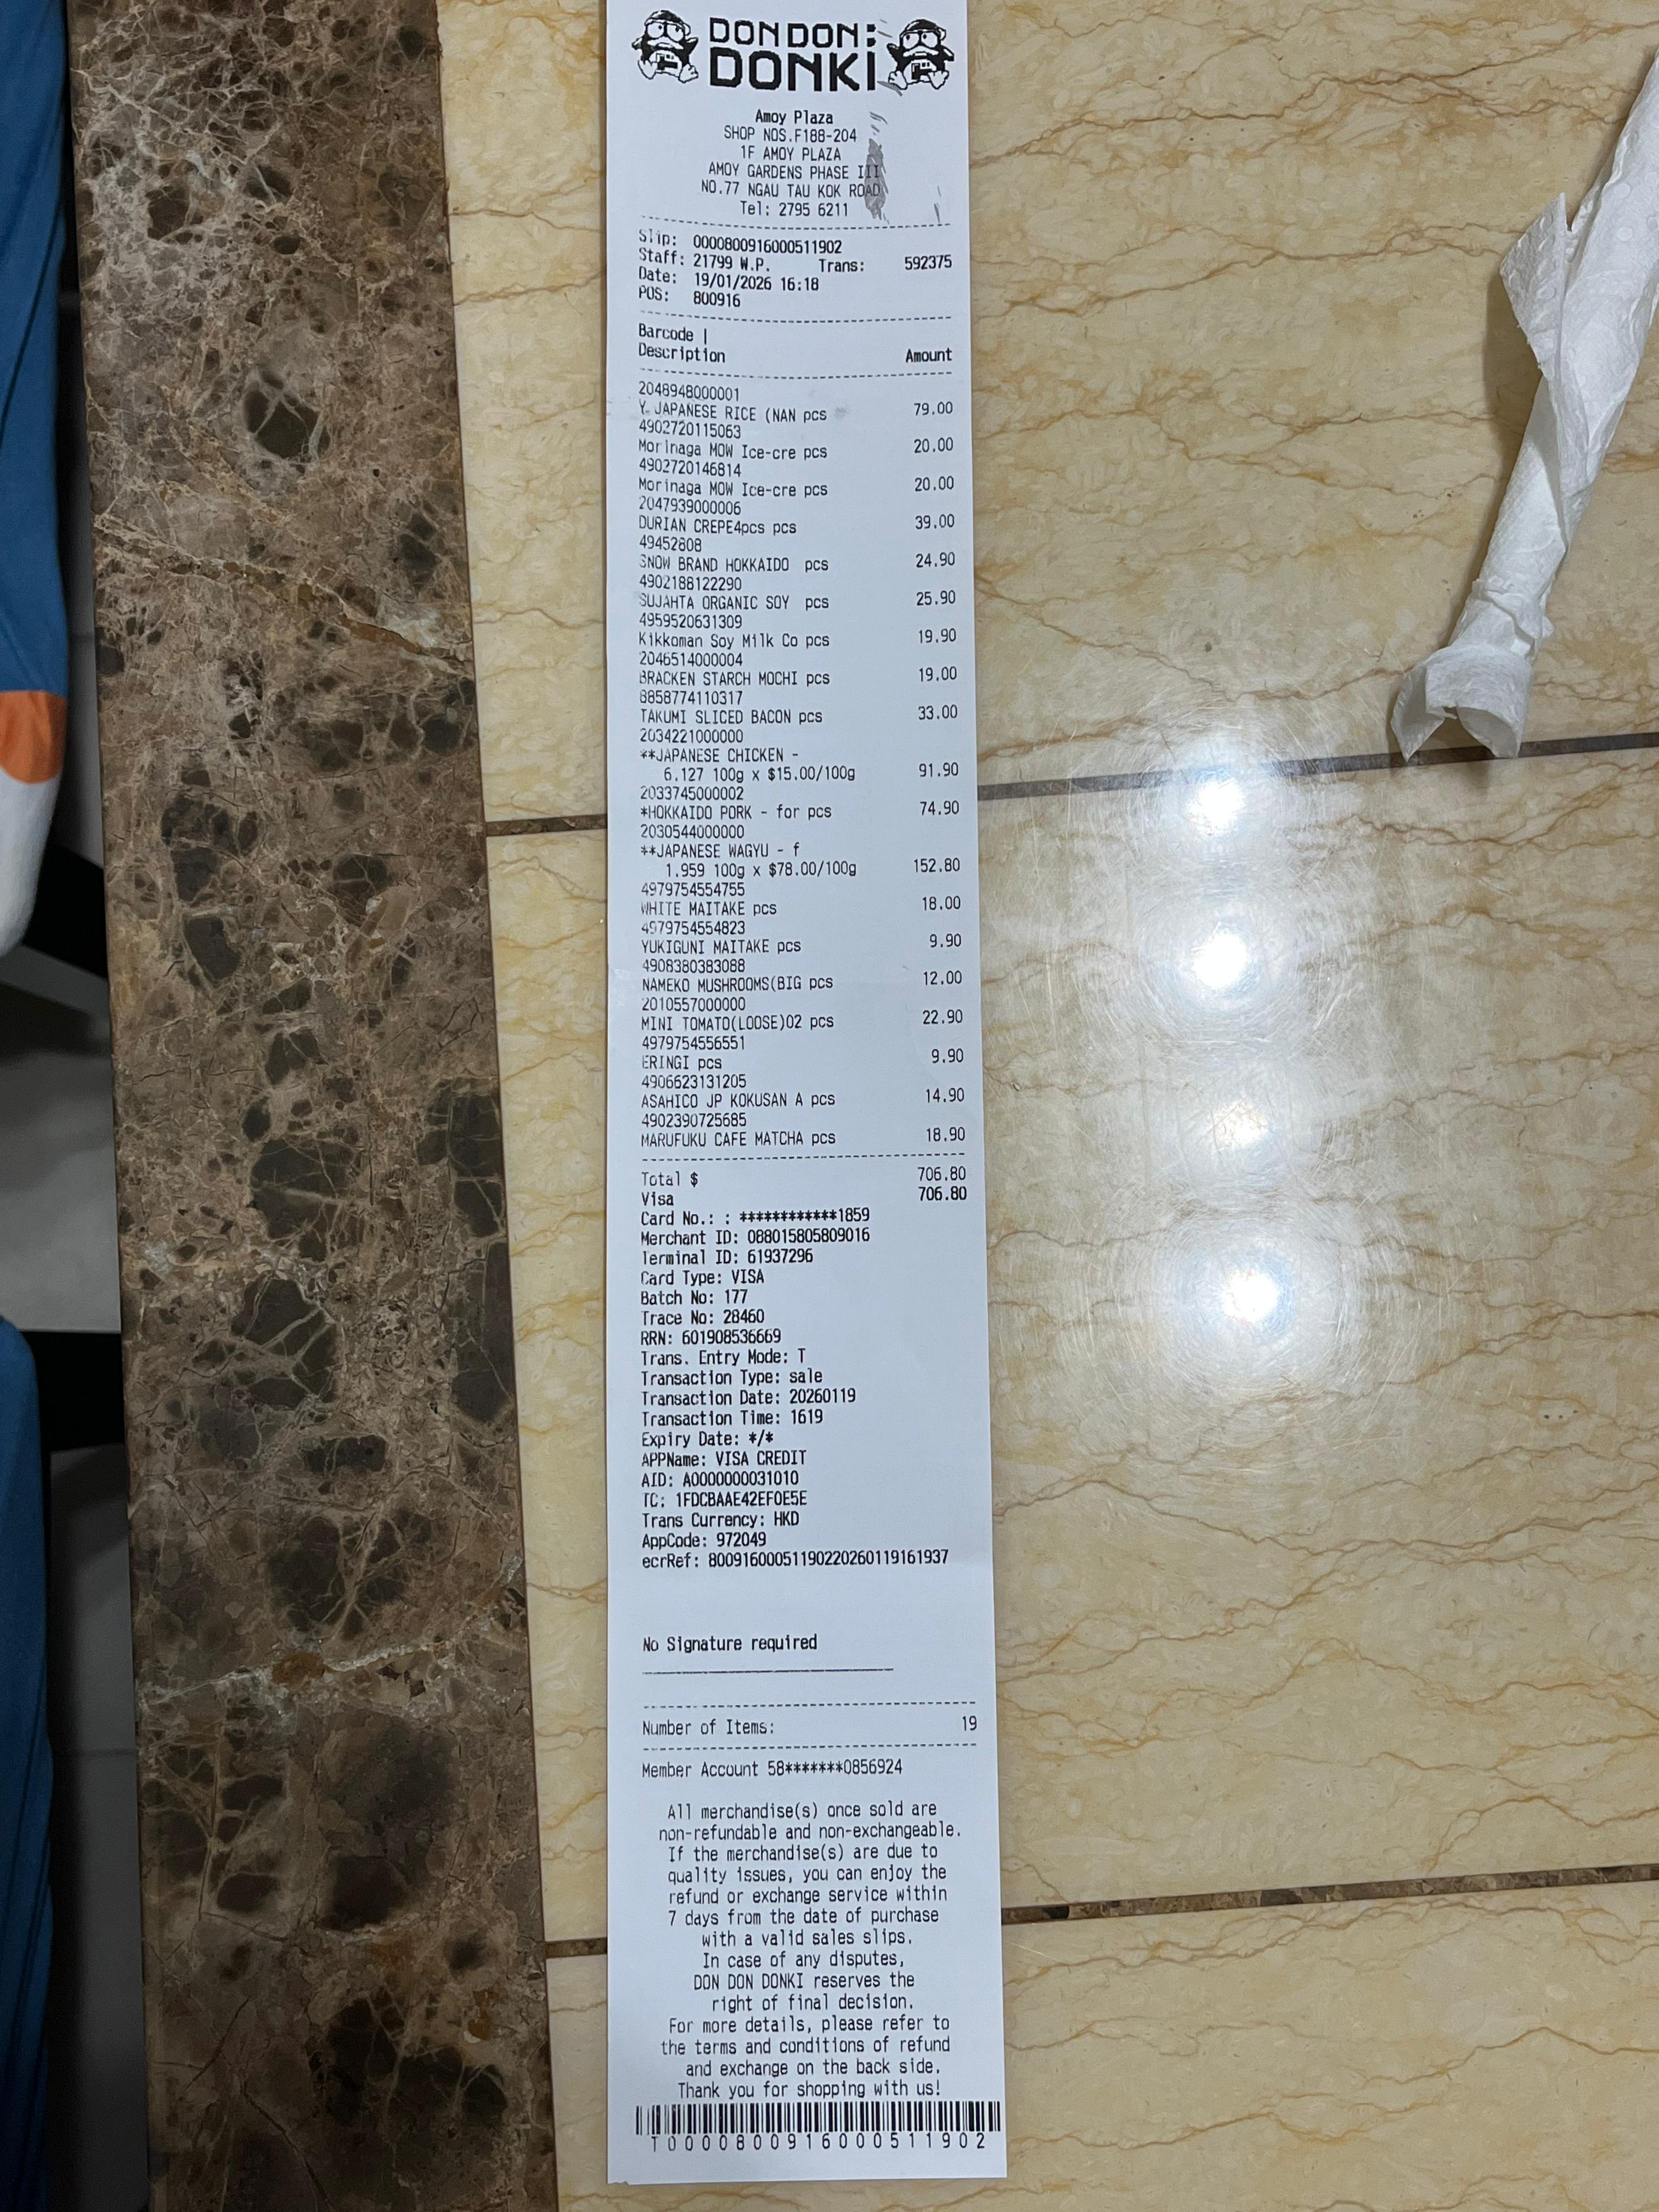

In [28]:
from IPython.display import HTML, display
import glob, os

image_paths = glob.glob("*.jpg")
image_paths.sort()
html_content = '<div style="display: flex; flex-wrap: wrap; gap: 20px;">'

for path in image_paths:
    b64 = image_to_base64(path)
    filename = os.path.basename(path) # Clean up path to show just the name

    # Create a vertical column for each image + text
    html_content += f'''
    <div style="display: flex; flex-direction: column; align-items: center;">
        <img src="data:image/jpeg;base64,{b64}" style="height: 300px; border: 1px solid #ddd; margin-bottom: 5px;"/>
        <span style="font-family: monospace; font-size: 14px;">{filename}</span>
    </div>
    '''

html_content += '</div>'

display(HTML(html_content))

## 2. Image input to Gemini
Different from text, image needs to be converted into base64 encoded string and then formated into url before inputting to the language model. This is convenient for image-type input to be transfered through the API.

You can find out more appropriate format for image-type data in this [Link](https://docs.langchain.com/oss/python/langchain/messages)



In [29]:
from langchain_core.prompts import ChatPromptTemplate
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant."),
    ("human", [
        {"type": "text", "text": "{question}"},
        {"type": "image_url", "image_url": {"url": "{image_url1}"}},
        {"type": "image_url", "image_url": {"url": "{image_url2}"}},
    ]),
])

chain = prompt | llm

image_path = "/content/receipt1.jpg"
image_data_url = get_image_data_url(image_path)

image_path2 = "/content/receipt2.jpg"
image_data_url2 = get_image_data_url(image_path2)

response = chain.invoke({
    "question": "What is in this picture?",
    "image_url1": image_data_url,
    "image_url2": image_data_url2
})

print(response.content)

The picture contains two retail receipts, likely from supermarkets in Hong Kong, given the language (Traditional Chinese and English), currency (HKD implied by context and store names), and payment method (Octopus card).

Here's a breakdown of what's on each receipt:

**Receipt 1 (Left Side):**

*   **Store Type:** Appears to be a grocery store or supermarket.
*   **Language:** Primarily Traditional Chinese with some English product names.
*   **Items Purchased (with approximate English translations):**
    *   Multiple packs of **Chive Pork Wontons** (菲菜豬肉雲吞20粒裝)
    *   **IF100% Coconut Water** (椰子水)
    *   **Jade Mango** (玉芒)
    *   **Fresh Mixed Orange Juice** (Fresh綜合橙汁)
    *   **Nestlé Skimmed High-Calcium Milk Drink** (雀巢脫脂高鈣牛奶飲品)
    *   **Mr. Wing's Packaged Tomatoes (Medium)** (榮先生包裝蕃茄 (中))
    *   **Mr. Wing's Zucchini/Courgette (1 lb)** (榮先生翠玉瓜1磅)
    *   **Steamed Pork Patty with Salted Egg** (咸蛋蒸肉餅)
    *   **Golden Imperial Vermicelli** (金御膳龍口粉絲)
    *   **Frozen Whel

In [30]:
import os
import json
import time
import base64
import concurrent.futures
from typing import List, Dict, Union, Any
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage

class ReceiptAgent:
    def __init__(self):
        # 1. SETUP
        api_key = os.environ.get("GEMINI_API_KEY")
        if not api_key:
            try:
                from google.colab import userdata
                api_key = userdata.get('GEMINI_API_KEY')
            except:
                pass

        # 2. MODEL
        self.llm = ChatGoogleGenerativeAI(
            model="gemini-2.5-flash",
            temperature=0.0,
            google_api_key=api_key
        )

        # 3. KNOWLEDGE CACHE
        # We only need math data now. No full text.
        self.data_cache = {}

    def _get_base64_uri(self, image_path: str):
        try:
            with open(image_path, "rb") as image_file:
                image_data = base64.b64encode(image_file.read()).decode("utf-8")
                return f"data:image/jpeg;base64,{image_data}"
        except:
            return None

    # --- PHASE 1: MATH-ONLY INGESTION ---
    def _ingest_single_image(self, image_path: str) -> Dict[str, float]:
        image_uri = self._get_base64_uri(image_path)
        if not image_uri: return None

        # Simplified prompt: Only cares about money.
        prompt = """
        Analyze this receipt. Return a JSON object with exactly two keys:

        1. "paid": (float) The Grand Total / Final Amount Paid.
        2. "savings": (float) The Total Savings/Discounts.
           - Look for labels like "You saved", "特價", "優惠".
           - Look for negative numbers (e.g. -2.00) that indicate coupons.
           - If no savings found, set to 0.0.

        Output strictly valid JSON. Example: {"paid": 12.50, "savings": 3.00}
        """
        try:
            msg = HumanMessage(content=[{"type": "text", "text": prompt}, {"type": "image_url", "image_url": image_uri}])
            res = self.llm.invoke([msg])
            text = res.content.replace("```json", "").replace("```", "").strip()
            data = json.loads(text)

            return {
                "paid": float(data.get("paid", 0.0)),
                "savings": float(data.get("savings", 0.0))
            }
        except:
            return {"paid": 0.0, "savings": 0.0}

    def ingest_data(self, image_paths: List[str]):
        # Filter for new images only
        new_images = [p for p in image_paths if p not in self.data_cache]
        if not new_images: return

        print(f"📥 INGESTION: Extracting financial data from {len(new_images)} images...")

        with concurrent.futures.ThreadPoolExecutor(max_workers=7) as executor:
            future_to_path = {executor.submit(self._ingest_single_image, p): p for p in new_images}

            for future in concurrent.futures.as_completed(future_to_path):
                path = future_to_path[future]
                data = future.result()
                if data:
                    self.data_cache[path] = data

        print(f"✅ CACHE UPDATE: {len(self.data_cache)} receipts ready.")

    # --- PHASE 2: STRICT ROUTING ---
    def _classify_intent(self, query: str) -> str:
        prompt = f"""
        Role: Strict Gatekeeper.

        Allowed Intents:
        1. [TOTAL_SPEND]: User asks for "total cost", "how much paid", "sum of bills", "final charge".
        2. [ORIGINAL_PRICE]: User asks for "original price", "price without discount", "full value", "before savings".

        Forbidden Intents (Must be IRRELEVANT):
        3. [IRRELEVANT]:
           - Asking for item lists ("what did I buy", "list vegetables").
           - Asking for store names, dates, or payment methods.
           - General questions ("weather", "coding").

        Query: "{query}"

        Return ONLY the category name.
        """
        try:
            res = self.llm.invoke(prompt).content.strip().upper()
            if "TOTAL" in res: return "TOTAL_SPEND"
            if "ORIGINAL" in res: return "ORIGINAL_PRICE"
            return "IRRELEVANT"
        except:
            return "IRRELEVANT"

    # --- PHASE 3: EXECUTION ---
    def run(self, image_paths: List[str], query: str) -> str:
        # 1. Ingest
        self.ingest_data(image_paths)

        # 2. Filter Data (Only use permitted images)
        active_data = []
        for path in image_paths:
            if path in self.data_cache:
                active_data.append(self.data_cache[path])

        if not active_data:
            return "Error: No data found."

        # 3. Route
        intent = self._classify_intent(query)

        # 4. Strict Logic
        if intent == "TOTAL_SPEND":
            # Pure Python Summation (High Reliability)
            total = sum(d["paid"] for d in active_data)
            return f"{total:.2f}"

        elif intent == "ORIGINAL_PRICE":
            # Pure Python Summation
            total = sum(d["paid"] + d["savings"] for d in active_data)
            return f"{total:.2f}"

        else:
            # Catch-all for IRRELEVANT (including "What did I buy?")
            return "I am a receipt analysis agent. I can only calculate Total Spend or Original Price. Your query appears unrelated to these calculations."

# Initialize
receipt_agent = ReceiptAgent()
print("✅ ReceiptAgent (Strict Mode) Ready.")

✅ ReceiptAgent (Strict Mode) Ready.


In [31]:
# 1. Get list of all jpg images
import glob
image_paths = sorted(glob.glob("*.jpg"))
print(image_paths)

# 2. Define the query
query1 = "How much money did I spend in total for these bills?"

# 3. Run the agent
# The agent will loop through all images, sum the 'paid' amounts, and return the result.
query1_answer = receipt_agent.run(image_paths, query1)

print(f"\nUser Query: {query1}")
print(f"Agent Answer: {query1_answer}")

['receipt1.jpg', 'receipt2.jpg', 'receipt3.jpg', 'receipt4.jpg', 'receipt5.jpg', 'receipt6.jpg', 'receipt7.jpg', 'receipt8.jpg']
📥 INGESTION: Extracting financial data from 8 images...
✅ CACHE UPDATE: 8 receipts ready.

User Query: How much money did I spend in total for these bills?
Agent Answer: 2681.10


## 3. Evaluation Code

* Make sure your LLM return a single float as the answer, stored in `query1_answer` and `query2_answer`
* Run the following code blocks: (1) If the blocks does not return any error, then your chain design is correct. Otherwise, please check your chain design.

* Do not modify `query_1_costs` and `query_2_costs`

In [32]:
def test_query(answer, ground_truth_costs):
    # Convert string to float if necessary
    if isinstance(answer, str):
        answer = float(answer)

    # Calculate the ground truth sum once for clarity
    expected_total = sum(ground_truth_costs)

    # Check if the answer is within +/- $2 of the expected total
    assert abs(answer - expected_total) <= 2

Run the following code block to evaluate query 1:
> How much money did I spend in total for these bills?

In [34]:
query_1_costs = [394.7, 316.1, 140.8, 514.0, 102.3, 190.8, 315.6, 706.8] # do not modify this
test_query(query1_answer, query_1_costs)

Run the following code block to evaluate query 2:
> How much would I have had to pay without the discount?

In [35]:
query2 = "How much would I have had to pay without the discount?"
query2_answer = receipt_agent.run(image_paths, query2)

print(f"\nUser Query: {query2}")
print(f"Agent Answer: {query2_answer}")


User Query: How much would I have had to pay without the discount?
Agent Answer: 3054.66


In [36]:
query_2_costs = [480.20, 392.20, 160.10, 590.80, 107.70, 221.20, 396.00, 706.8] # do not modify this

test_query(query2_answer, query_2_costs)

In [37]:
import math
import concurrent.futures
import time

# --- 1. SETUP ---
print("⚙️ PRE-FLIGHT: Ingesting Data...")
receipt_agent.ingest_data(image_paths)

gt_costs_total = [394.7, 316.1, 140.8, 514.0, 102.3, 190.8, 315.6, 706.8]
gt_costs_original = [480.20, 392.20, 160.10, 590.80, 107.70, 221.20, 396.00, 706.8]

def run_single_test(test_id, query, eval_type, expected_data=None):
    try:
        agent_ans = receipt_agent.run(image_paths, query)

        output = []
        output.append(f"\n--- Test {test_id} ---")
        output.append(f"Query: {query}")
        output.append(f"Answer: {agent_ans}")

        if eval_type == "MATH":
            expected_sum = sum(expected_data)
            try:
                val = float(agent_ans)
                error = abs(val - expected_sum)
                is_pass = error < (expected_sum * 0.05)
                status = "✅ PASS" if is_pass else f"❌ FAIL (Diff: {error:.2f})"
                output.append(f"Result: {status} | Agent: {val:.2f}")
            except:
                output.append(f"Result: ❌ FAIL (Non-numeric)")

        elif eval_type == "REJECTION":
            # We explicitly want the agent to REFUSE these now
            keywords = ["cannot answer", "irrelevant", "unrelated", "receipt analysis agent", "only calculate"]
            if any(k in agent_ans.lower() for k in keywords):
                output.append("Result: ✅ PASS (Correctly Rejected)")
            else:
                output.append(f"Result: ❌ FAIL (Agent tried to answer)")

        return test_id, "\n".join(output)

    except Exception as e:
        return test_id, f"Error: {e}"

# --- 2. STRICT TEST SUITE ---
tests = [
    # MATH (Should Answer)
    (1, "How much money did I spend in total for these bills?", "MATH", gt_costs_total),
    (2, "Calculate the final sum of payments I made.", "MATH", gt_costs_total),
    (3, "How much would I have had to pay without the discount?", "MATH", gt_costs_original),
    (4, "What was the full price of the items before any savings?", "MATH", gt_costs_original),

    # GENERAL/IRRELEVANT (Should Reject per HW instructions)
    (5, "Did I buy any milk?", "REJECTION", None),
    (6, "What are the store names?", "REJECTION", None),
    (7, "List all vegetables.", "REJECTION", None),
    (8, "Who won the World Cup?", "REJECTION", None),
    (9, "Write python code.", "REJECTION", None),
    (10, "List all payment methods.", "REJECTION", None)
]

# --- 3. EXECUTE ---
print("="*60)
print(f"🚀 STARTING STRICT EVALUATION...")
print("="*60)

results = []
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    future_to_test = {executor.submit(run_single_test, t[0], t[1], t[2], t[3]): t[0] for t in tests}
    for future in concurrent.futures.as_completed(future_to_test):
        tid, res_str = future.result()
        results.append((tid, res_str))
        print(f"✅ Test {tid} completed.")

print("\n" + "="*60)
print("📊 FINAL REPORT")
print("="*60)
results.sort(key=lambda x: x[0])
for _, res in results:
    print(res)

⚙️ PRE-FLIGHT: Ingesting Data...
🚀 STARTING STRICT EVALUATION...
✅ Test 1 completed.
✅ Test 7 completed.
✅ Test 6 completed.
✅ Test 9 completed.
✅ Test 10 completed.
✅ Test 3 completed.
✅ Test 2 completed.
✅ Test 5 completed.
✅ Test 4 completed.
✅ Test 8 completed.

📊 FINAL REPORT

--- Test 1 ---
Query: How much money did I spend in total for these bills?
Answer: 2681.10
Result: ✅ PASS | Agent: 2681.10

--- Test 2 ---
Query: Calculate the final sum of payments I made.
Answer: 2681.10
Result: ✅ PASS | Agent: 2681.10

--- Test 3 ---
Query: How much would I have had to pay without the discount?
Answer: 3054.66
Result: ✅ PASS | Agent: 3054.66

--- Test 4 ---
Query: What was the full price of the items before any savings?
Answer: 3054.66
Result: ✅ PASS | Agent: 3054.66

--- Test 5 ---
Query: Did I buy any milk?
Answer: I am a receipt analysis agent. I can only calculate Total Spend or Original Price. Your query appears unrelated to these calculations.
Result: ✅ PASS (Correctly Rejected)

--

In [21]:
# --- Interactive Chat Loop ---

print("="*60)
print("💬 RECEIPT AGENT CHATBOT")
print("Type your question below. Type 'exit', 'quit', or 'q' to stop.")
print("="*60)

while True:
    # 1. Get User Input
    user_input = input("\nUser: ").strip()

    # 2. Check for Exit Condition
    if user_input.lower() in ["exit", "quit", "q", "no", "stop"]:
        print("\n👋 Ending chat session. Goodbye!")
        break

    # 3. Skip empty inputs
    if not user_input:
        continue

    # 4. Run Agent
    try:
        # Visual loading indicator
        print("   Thinking...", end="\r")

        response = receipt_agent.run(image_paths, user_input)

        # Clear loading line and print response
        print(" " * 20, end="\r")
        print(f"Agent: {response}")
        print("-" * 60)

    except NameError:
        print("❌ Error: 'receipt_agent' or 'image_paths' not defined. Run the setup cells first.")
        break
    except Exception as e:
        print(f"❌ Error: {e}")

💬 RECEIPT AGENT CHATBOT
Type your question below. Type 'exit', 'quit', or 'q' to stop.

User: i spent how many dollars in total?
Agent: 2681.10
------------------------------------------------------------

User: i spent how many dollars in total if there were no discounts at all?
Agent: 3054.66
------------------------------------------------------------

User: i spent how much on average?
Agent: I am a receipt analysis agent. I can only calculate Total Spend or Original Price. Your query appears unrelated to these calculations.
------------------------------------------------------------

User: exit

👋 Ending chat session. Goodbye!
